**Candidate Number: 237707**

**Word Count: 1844 (with in text latex equations regarded as one single word)**

# **Imports**

In [ ]:
# Importing Libraries
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from nltk import FreqDist 
import time
import math 
import pandas as pd
import scipy.stats as stats
from collections import defaultdict
from multiprocessing import Pool
nltk.download("gutenberg")



[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

# **==== INTRODUCTION (REPORT) ====**

This report investigates the worst case runtimes of the Jaccard similarity algorithm as well as  various implementations of the Cosine similarity algorithms. As a starting point, experimentations and analysis will be centred on “gutenberg” corpus from the NLTK library and represented as a bag of words. 
 
In question 1, various experimentations are carried out to examine worst-case runtimes of the Jaccard similarity in sparse representation. Subsequently, question 2 will focus on comparing worst-case runtimes of cosine similarity (dense vector representation) compared to an implementation using numpy. Thereafter, question 3 aims to establish the worst-case runtime of the cosine similarity algorithm in a sparse representation and compare previous results obtained of the worst-case runtimes of jaccard similarity algorithm (question 1) and implementations of the cosine similarity in dense vector representation (question 2).
 
Question 4 will focus on the worst case run times of computing all pair similarities using a collection of 18 documents from the gutenberg corpus (in sparse representation for both algorithms). Moreover, an estimation of runtime of computing the all pair similarities of 200,000 documents will also be provided. Finally in question 5, a parallel implementation of map-reduce will aim to curtail the average run times of computing all pair similarities of the 18 documents from the gutenberg corpus using both the jaccard and cosine similarity algorithms (in sparse representation).



# **==========================**

# **Question 1 Class**

In [ ]:
# A class for jaccards similarity which includes all methods needed to answer question 1
class Jaccards:

  def __init__(self):
    pass

  # === The following 3 methods will be used in question 2 and question 3 ===
  
  # Returns a list of word as bag of word (in a dictionary)
  # Parameters: A list of words  
  def word_to_dict(self, word_list):
    return {word: freq for word, freq in FreqDist(word_list).items()}
  
  # Returns the slope, intercept and standard deviation error for given dataset 
  # Parameters: x and y 
  def slope_intercept_std(self, x, y):
    # Using scipy library to find key metrics for our data
    slope, intercept, _, _, std_error = stats.linregress(x, y)
    return slope, intercept, std_error
  
  # Returns a pandas data frame for displaying slope, intercept and standard deviation error both the actual data and the logs of given data
  # Parameters: Pandas dataframe created using increacing_wordList() (it can be found below) 
  def slope_df(self, df):
    # Creating lists from pandas dataframe
    actual_times = list(df["Time"])
    actual_words = list(df["Word Count"])
    log_times = list(df["Log Time"])
    log_words = list(df["Log Word Count"])
    # Using slope_intercept_std() method to find key metrics for our data
    slope, intercept, std_error = self.slope_intercept_std(actual_words, actual_times)
    slope_log, intercept_log, std_error_log = self.slope_intercept_std(log_words, log_times)
    # Adjusting data to use in pandas 
    labels = ["Slope", "Intercept", "STD Error"]
    data_ = [slope, intercept, std_error]
    log_data = [slope_log, intercept_log, std_error_log]
    # Returning a pandas dataframe
    df = pd.DataFrame(data = {"Metric": labels, "Actual Data": data_, "Log Data": log_data})
    return df

  # Returns the sum of values in dictionary - using for loop
  # Parameters: A dictionary (representing our bag of words)  
  def findTotal_FL(self, myDict):
    total=0
    for item in myDict:
      total += myDict[item]
    return total

  # Returns the sum of values in dictionary - using for the sum() and dict.values() methods
  # Parameters: A dictionary (representing our bag of words)  
  def findTotal_SV(self, myDict):
    return sum(myDict.values())

  # Returns Jaccard's similarity
  # Parameters: Two dictionaries (representing our bag of words for calculating the similarity)    
  def jaccards(self, dict_1, dict_2):
    # Dictionary comprehension used to find intersections 
    total_intersection = self.findTotal_SV({item: min(dict_1[item], dict_2[item]) for item in dict_1.keys() if item in dict_2.keys()})
    # Calculating union
    union = self.findTotal_SV(dict_1) + self.findTotal_SV(dict_2) - total_intersection
    return total_intersection/union # Calculating Jaccard's similarity
  
  # Measures the run time of the findTotal_FL() and findTotal_SV() methods (abbove)
  # Returns a pandas data frame with run times (with increacing word counts)
  def measure_findTotal(self):
    # Empty list to gather our results
    times_FL = []
    times_SV = []
    word_counts = []
    # The gutenberg corpus
    corpus = gutenberg.words()
    for word_count in range(1000, 30001, 30):
      # Using the word_to_dict() to create a bag of words (using the for loop to determine size)
      token = self.word_to_dict(corpus[:word_count])
      word_counts.append(word_count)
      # Measuring runtime of findTotal_FL()  
      start = time.time()
      ans = self.findTotal_FL(token)
      run_time = time.time() - start
      times_FL.append(run_time)
      # Measuring runtime of findTotal_SV()  
      start = time.time()
      ans = self.findTotal_SV(token)
      run_time = time.time() - start
      times_SV.append(run_time)
    # Returning results in a pandas dataframe
    return pd.DataFrame(data={"Word Count": word_counts, "Function 1": times_FL, "Function 2": times_SV})

  # Returns results of runtimes jaccard's similarity algorithm against increacing size of words 
  # Parameters: Maximum words (max_words) that will be used to test run time of algorithm
  # Parameters: Plot length (plot_length) determines how many data points will be plotted
  # Parameters: Epochs (epochs) is number of iterations that will be used to find the avergage runtime
  def increacing_wordList(self, max_words, plot_length, epochs):
    # Sorting the increace in word count (will be used in the for loop below)
    range_min, range_max, range_diff = int(max_words/plot_length), int(max_words), int(max_words/plot_length)
    # The gutenberg corpus
    corpus = gutenberg.words()
    # Empty list to gather our results
    word_counts = []
    average_times = []
    simmilarities = []
    # Loop based on values provided in parameter (sorted above)
    for word_count in range(range_min, range_max+1, range_diff):
      # Empty list to collect run average time (from total epochs) 
      times = []
      # Adjusting size of word list  
      tok_a = self.word_to_dict(corpus[:word_count])
      tok_b = self.word_to_dict(corpus[word_count:word_count*2])
      for i in range(epochs):
        # Computing run times 
        start = time.time()
        ans = self.jaccards(tok_a, tok_b)
        run_time = time.time() - start
        times.append(run_time)
        if i == epochs-1:
          # Appending averag time, word count and similarity score 
          simmilarities.append(ans)
          average_time = np.mean(times)
          average_times.append(average_time)
          word_counts.append(word_count)
    # Finding logs of words count and average run times
    log_word = [np.log10(w) for w in word_counts]
    log_time = [np.log10(t) for t in average_times]
    # Returning results in pandas dataframe 
    df = pd.DataFrame(data={"similarity": simmilarities, "Word Count": word_counts, "Time": average_times, "Log Word Count": log_word, "Log Time": log_time})
    return df


# Initializing the jaccards class 
Jac =  Jaccards()



# **Figures 1.1 - 1.2:** Implementation of Algorithms



**The following function may be used to calculate the sum of values in our dictionary**

Function 1: Uses for loop to calculate the sum

Function 2: Uses sum() and dict.values method()

***Figure 1.1:*** Panada data frame with calculations of run times with the word count increacing from 1,000 to 100,000 words.

In [ ]:
df_alg = Jac.measure_findTotal()
df_alg

,Word Count,Function 1,Function 2
0,1000,0.000057,0.000012
1,1030,0.000069,0.000011
2,1060,0.000057,0.000006
3,1090,0.000038,0.000006
4,1120,0.000038,0.000006
...,...,...,...
962,29860,0.000272,0.000031
963,29890,0.000258,0.000031
964,29920,0.000262,0.000032
965,29950,0.000278,0.000031


***Figure 1.2:*** plotting run time against increacing word count (1,000 to 100,000 words)

Text(0.5, 1.0, 'Comparing Run Time of Function 1 and Function 2')

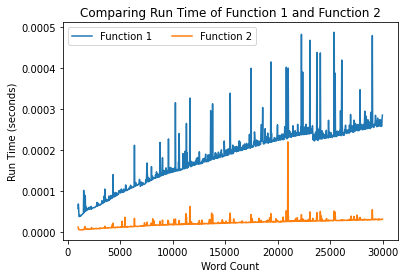

In [ ]:
# Using matplotlib to plot
plt.plot(df_alg["Word Count"], df_alg["Function 1"])
plt.plot(df_alg["Word Count"], df_alg["Function 2"])
label = ["Function 1", "Function 2"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Run Time (seconds)")
plt.xlabel("Word Count")
plt.title("Comparing Run Time of Function 1 and Function 2")


# **Figures 1.3 - 1.7:** Comparing Jaccards Similarity Algorithm

**Pandas Data Frame**

***Figure 1.3:*** In this table the run time of jaccard's similarity is calculated with increacing word counts ranging from 1,000 words to 50,000 words

In [ ]:
# set up 
max_words = 50000
plot_length = 50
epochs = 10 

In [ ]:
# Creating dataframe for results
df_increacing = Jac.increacing_wordList(max_words, plot_length, epochs)
df_increacing

,similarity,Word Count,Time,Log Word Count,Log Time
0,0.344086,1000,0.000115,3.000000,-3.938623
1,0.405481,2000,0.000186,3.301030,-3.730231
2,0.490313,3000,0.000240,3.477121,-3.620278
3,0.459321,4000,0.000283,3.602060,-3.547661
4,0.519064,5000,0.000345,3.698970,-3.462011
5,0.558846,6000,0.000382,3.778151,-3.417591
6,0.553484,7000,0.000426,3.845098,-3.370268
7,0.541723,8000,0.000462,3.903090,-3.335194
8,0.540041,9000,0.000499,3.954243,-3.302306
9,0.541663,10000,0.000540,4.000000,-3.267515


**Analysis of Runtime**

***Figure 1.4:*** Plot illustrates the worst case run time of jaccard's similarity with the size of words increacing from 1000 - 50,000

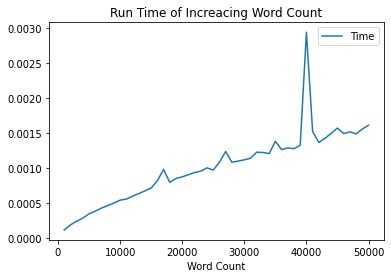

In [ ]:
# Using pandas to plot from dataframe
title_ = "Run Time of Increacing Word Count"
df_increacing.plot(x="Word Count", y="Time", title=title_)

***Figure 1.5*** Scatter plot illustrates the worst case run time of jaccard's similarity with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs)

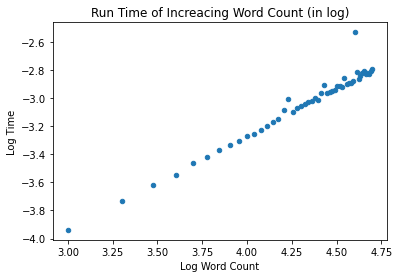

In [ ]:
# Using pandas to plot from dataframe
title_ = "Run Time of Increacing Word Count (in log)"
df_increacing.plot.scatter(x="Log Word Count", y="Log Time", title=title_)

***Figure 1.6*** Metrics of the polts above derived from pandas dataframe in figure 1.3

In [ ]:
# Using the slope_df() method to get metrics in pandas dataframe
Jac.slope_df(df_increacing)

,Metric,Actual Data,Log Data
0,Slope,3.054053e-08,0.688860
1,Intercept,2.341179e-04,-6.015831
2,STD Error,2.278346e-09,0.018889


**Analysis of Similarities**

***Figure 1.7:*** Plot of change in jaccard's similarity in response to increacing size of words from 1,000 - 50,000

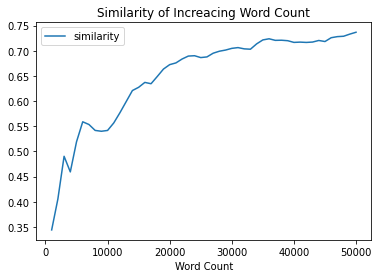

In [ ]:
# Using pandas to plot from dataframe
title_ = "Similarity of Increacing Word Count"
df_increacing.plot(x="Word Count", y="similarity", title=title_)

# **==== QUESTION 1 (REPORT) ====**

**Implementation of Jaccard's Similarity**
 
Jaccard’s similarity index can be conceptualised as total observations present in both sets (size of intersection) divided by total observations in either sets (size of union) represented by the following notation **$J(A,B) =\frac{ \left| A\bigcap_{}^{}B{} \right| }{|A\bigcup_{}^{}B|}$**. Respectively, jaccard’s similarity is implemented by:
 
 
1. Computing sum of frequencies of intersecting words in both sets.
2. Computing the unions using sum frequencies in both sets subtracted by total sum of intersections.
3. Dividing total sum of intersection in both sets by the union.
 
In this respect, the length of the documents (keys in our bag of words) have the most significant impact on the worst case runtime. Therefore, an experiment was carried out to find the most effective method of computing the sum of the values in the dictionary which is used to find both the union as well as intersections. It was concluded that using the built in sum() and dict.values() drastically improves runtime [figures 1.1 - 1.2].
 
 
 
**Experimentations and Analysis**

Results collected  in figure 1.1 (data frame) suggest the average runtime and similarity index to increase along with word count. Respectively, figure 1.7 exhibits significant increase in similarity until 10,000 words followed by more modest increase suggesting documents run out of common words that intersect. On the other hand, the average runtime appears to grow more steadily (against word count) despite irregularities seen with the peak in figure 1.4. This is also consistent with the outlier exhibited in the scatter graph [figure 1.5].
 
**Estimation of Constants**

If **$y=ax^{b}$**, then **$log(y) = log(x)b+log(a)$** where **$b$** is the slope and **$a$** is the intercept.  Respectively, figure 1.6 displays results computed (using the scipy library) with the gradient at 0.69 and the intercept at -6.02 (**$\approx 6$**) meaning that **$y\approx x^{0.69}*10^{-6}$**. The estimation can be  verified as $50000^{0.69}*10^{-6.02} = 0.0017 \approx 0.0016$ (the result in figure 1.3). Therefore, the worst case runtime can be denoted as **$O(n^{0.69})$**.



In [ ]:
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -6.02# Intercept 
b = 0.69# Slope
x = 50000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

0.0016683582105409846

# **==========================**

# **Question 2 Class**

In [ ]:
class Cosine:

  def __init__(self, jaccard):
    self.jaccard = jaccard
    
  # === The following 3 methods will be used from the jaccards class ===

  # Returns a pandas data frame for displaying slope, intercept and standard deviation error both the actual data and the logs of given data
  # Parameters: Pandas dataframe created using increacing_wordList() (it can be found below) 
  def slope_intercept_std(self, x, y):
    return self.jaccard.slope_intercept_std(x, y)

  # Returns the slope, intercept and standard deviation error for given dataset 
  # Parameters: x and y 
  def slope_df(self, df):
    return self.jaccard.slope_df(df)

  # Returns a list of word as bag of word (in a dictionary)
  # Parameters: A list of words 
  def word_to_dict(self, word_list):
    return self.jaccard.word_to_dict(word_list)

  # Returns vectorized bag of words 
  # Parameters: A list of dictionaries (our bag of words)  
  def create_matrix(self, list_of_dict):
    # initialize a dictionary for our features 
    myDict = {}
    # Adding all keys in our document in the empty dictionary with values initialized as 1 
    for doc in list_of_dict:
      for feature in doc.keys():
        myDict[feature] = 1
    # Creating a list of all keys in dictionary 
    dimensions = list(myDict.keys())
    sorted_dimensions = sorted(dimensions) # Sorting the list above
    # Returning vector from our bag of words 
    return [[doc.get(dimension, 0) for doc in list_of_dict] for dimension in dimensions]
  
  # Returns the transpose of a matrix 
  # Parameters: Takes a matrix represented as a list 
  def transpose(self, matrix):
    return [[row[idx] for row in matrix] for idx in range(0, len(matrix[0]))]

  # Calculates the sum of tokens for cosine similarity (as vector)
  # Parameters: Takes vectorized tokens 
  def find_sum(self, tokens):
    total = sum([i**2 for i in tokens])
    return total**0.5
  
  # Returns cosine similarity 
  # Parameters: Takes two vectorized tokens 
  def cosine_simmilarity(self, tok_a, tok_b):
    # Initlize dot product as 0
    dot_product = 0
    # Finding sum of vectorized tokens using find_sum() method
    sum_a = self.find_sum(tok_a)
    sum_b = self.find_sum(tok_b)
    # Computing the dot product
    for i in range(len(tok_a)):
      dot_product += tok_a[i] * tok_b[i]
    # Returning cosine similarity 
    return dot_product/(sum_a*sum_b)

  def cosine_numpy(self, tok_a, tok_b):
    # Computing the dot product using numpy
    dot_product = np.dot(tok_a, tok_b)
    # Finding sum of vectorized tokens using find_sum() method
    sum_a = self.find_sum(tok_a)
    sum_b = self.find_sum(tok_b)
    # Returning cosine similarity 
    return dot_product/(sum_a*sum_b)

  # Returns results of runtimes cosine similarity algorithm against increacing size of words (with and without numpy)
  # Parameters: Maximum words (max_words) that will be used to test run time of algorithm
  # Parameters: Plot length (plot_length) determines how many data points will be plotted
  # Parameters: Epochs (epochs) is number of iterations that will be used to find the avergage runtime
  def increacing_wordList(self, max_words, plot_length, epochs):
    # Sorting the increace in word count (will be used in the for loop below)
    range_min, range_max, range_diff = int(max_words/plot_length), int(max_words), int(max_words/plot_length)
    # The gutenberg corpus
    corpus = gutenberg.words()
    # Empty list to gather our results (without using numpy)
    word_counts = []
    average_times = []
    similarities = []
    # Empty list to gather our results (using numpy)
    average_times_numpy = []
    similarities_numpy = []

    for word_count in range(range_min, range_max+1, range_diff):
      # Empty list to collect run average time (from total epochs) 
      times = []
      times_numpy = []
      # Adjusting size of word list  
      tok_a = self.word_to_dict(corpus[:word_count])
      tok_b = self.word_to_dict(corpus[word_count:word_count*2])
      tok_a, tok_b = np.array(self.transpose(self.create_matrix([tok_a, tok_b])))
      for i in range(epochs+1):
        # Computing run times (without numpy)
        start = time.time()
        ans = self.cosine_simmilarity(tok_a, tok_b)
        run_time = time.time() - start
        times.append(run_time)
        # Computing run times (with numpy)
        start = time.time()
        ans_np = self.cosine_numpy(tok_a, tok_b)
        run_time = time.time() - start
        times_numpy.append(run_time)
        if i == epochs:
          # Appending average time, word count and similarity score
          word_counts.append(word_count)
          similarities_numpy.append(ans_np)
          similarities.append(ans)
          average_time = np.mean(times_numpy)
          average_times_numpy.append(average_time)
          average_time = np.mean(times)
          average_times.append(average_time)  
    # Finding logs of words count and average run times
    log_word = [np.log10(w) for w in word_counts]
    log_time = [np.log10(t) for t in average_times]
    log_time_numpy = [np.log10(t) for t in average_times_numpy]
    # Returning results in pandas dataframe 
    df = pd.DataFrame(data={"similarity": similarities,"Word Count": word_counts, "Time": average_times, "Log Word Count": log_word, "Log Time": log_time})
    df_numpy = pd.DataFrame(data={"similarity": similarities_numpy, "Word Count": word_counts, "Time": average_times_numpy, "Log Word Count": log_word, "Log Time": log_time_numpy})
    return df, df_numpy

# Initializing the Cosine class 
cos = Cosine(Jac)


# **Figures 2.1 -2.5:** Analysis of Cosine Simmilarity Algorithm Without NumPy

***Pandas Data Frame***

In [ ]:
# Setup 
max_words = 50000
plot_length = 50
epochs = 10 
df_increacing, df_numpy = cos.increacing_wordList(max_words, plot_length, epochs)

***Figure 2.1:*** In this table the run time of cosine similarity is calculated with increacing word counts ranging from 1,000 words to 50,000 words

In [ ]:
# Pandas datafram
df_increacing

,similarity,Word Count,Time,Log Word Count,Log Time
0,0.870456,1000,0.001467,3.000000,-2.833567
1,0.873228,2000,0.001425,3.301030,-2.846163
2,0.947996,3000,0.001895,3.477121,-2.722397
3,0.929282,4000,0.002312,3.602060,-2.635941
4,0.962668,5000,0.002568,3.698970,-2.590430
5,0.976660,6000,0.002895,3.778151,-2.538285
6,0.970721,7000,0.003153,3.845098,-2.501333
7,0.958788,8000,0.003409,3.903090,-2.467396
8,0.957799,9000,0.003558,3.954243,-2.448801
9,0.953885,10000,0.003874,4.000000,-2.411814


**Analysis of Runtime**

***Figure 2.2:*** Plot illustrates the worst case run time of cosine similarity with the size of words increacing from 1000 - 50,000.

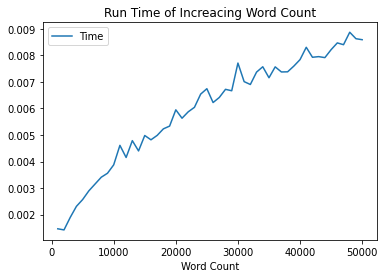

In [ ]:
# plot using matplotlib
title_ = "Run Time of Increacing Word Count"
df_increacing.plot(x="Word Count", y="Time", title=title_)

***Figure 2.3:*** Scatter plot illustrates the worst case run time of cosine similarity with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs)

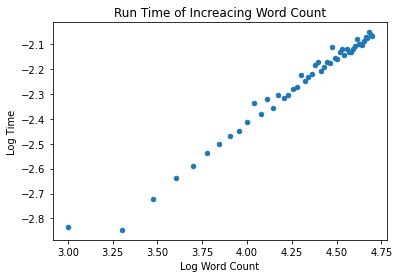

In [ ]:
# scatter plot using matplotlib
title_ = "Run Time of Increacing Word Count"
df_increacing.plot.scatter(x="Log Word Count", y="Log Time", title=title_)

**Analysis of Similarity**

***Figure 2.4:*** Plot of change in cosine similarity in response to increacing size of words from 1,000 - 50,000

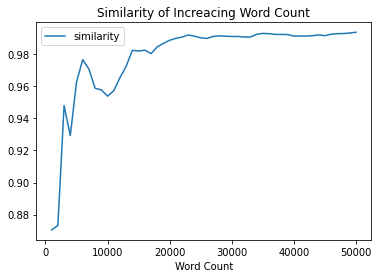

In [ ]:
# plot using matplotlib
title_ = "Similarity of Increacing Word Count"
df_increacing.plot(x="Word Count", y="similarity", title=title_)

# **Figures 2.5 - 2.7:** Analysis of Cosine Simmilarity Algorithm With NumPy

**Pandas Dataframe**


***Figure 2.5:*** In this table the run time of cosine similarity (using NumPy) is calculated with increacing word counts ranging from 1,000 words to 50,000 words

In [ ]:
# Pandas dataframe
df_numpy

,similarity,Word Count,Time,Log Word Count,Log Time
0,0.870456,1000,0.001111,3.000000,-2.954384
1,0.873228,2000,0.000957,3.301030,-3.019083
2,0.947996,3000,0.001220,3.477121,-2.913807
3,0.929282,4000,0.001544,3.602060,-2.811274
4,0.962668,5000,0.001695,3.698970,-2.770818
5,0.976660,6000,0.001917,3.778151,-2.717291
6,0.970721,7000,0.002110,3.845098,-2.675792
7,0.958788,8000,0.002381,3.903090,-2.623205
8,0.957799,9000,0.002353,3.954243,-2.628319
9,0.953885,10000,0.002634,4.000000,-2.579462


**Analysis of Runtime**

***Figure 2.6:*** Plot illustrates the worst case run time of cosine similarity (using NumPy) with the size of words increacing from 1000 - 50,000.

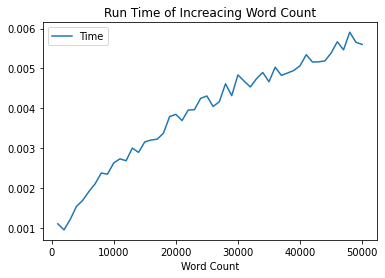

In [ ]:
# plot using matplotlib
title_ = "Run Time of Increacing Word Count"
df_numpy.plot(x="Word Count", y="Time", title=title_)

**Analysis of Similarity**

***Figure 2.7:*** Scatter plot illustrates the worst case run time of cosine similarity (using NumPy) with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs)

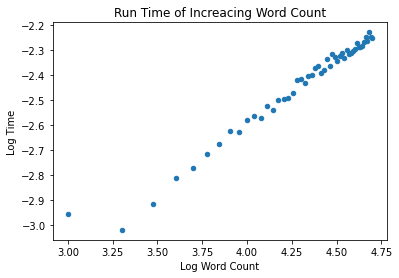

In [ ]:
# scatter plot using matplotlib
title_ = "Run Time of Increacing Word Count"
df_numpy.plot.scatter(x="Log Word Count", y="Log Time", title=title_)

# **Figures 2.8 - 2.10:** Comparison of Cosine Simmilarity Algorithm With and Without NumPy

***Figure 2.8:*** Plot compares the worst case run time of cosine similarity (with and without using Numpy) with the size of words increacing from 1000 - 50,000.

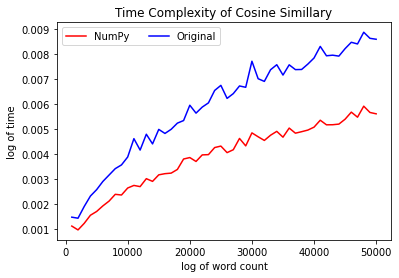

In [ ]:
# plot using matplotlib
plt.plot(df_numpy["Word Count"], df_numpy["Time"], color="red")
plt.plot(df_increacing["Word Count"], df_increacing["Time"], color="blue")
label = ["NumPy", "Original"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("log of time")
plt.xlabel("log of word count")
plt.title("Time Complexity of Cosine Simillary")
plt.show()

***Figure 2.9:*** Scatter plot compares the worst case run time of cosine similarity (with and without using Numpy) with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs).

Text(0.5, 1.0, 'Time Complexity of Cosine Simillary')

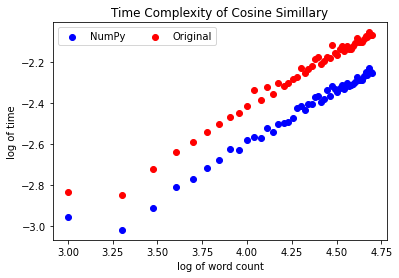

In [ ]:
# scatter plot using matplotlib
plt.scatter(df_numpy["Log Word Count"], df_numpy["Log Time"], color="blue")
plt.scatter(df_increacing["Log Word Count"], df_increacing["Log Time"], color="red")
label = ["NumPy", "Original"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("log of time")
plt.xlabel("log of word count")
plt.title("Time Complexity of Cosine Simillary")


***Figure 2.10:*** Metrics

In [ ]:
# Using the slope_df() method to get metrics in pandas dataframe
print("Cosine Metrics (without NumPy)")
cos.slope_df(df_increacing)

Cosine Metrics (without NumPy)


,Metric,Actual Data,Log Data
0,Slope,1.383124e-07,0.514658
1,Intercept,2.418286e-03,-4.470498
2,STD Error,5.052542e-09,0.009499


In [ ]:
# Using the slope_df() method to get metrics in pandas dataframe
print("Cosine Metrics (with NumPy)")
cos.slope_df(df_numpy)

Cosine Metrics (with NumPy)


,Metric,Actual Data,Log Data
0,Slope,9.014574e-08,0.500611
1,Intercept,1.599251e-03,-4.592222
2,STD Error,3.133713e-09,0.010785


# **==== QUESTION 2 (REPORT) ====**

**Implementation of Jaccard's Similarity**
 
Cosine similarity index measures cosines between angles of two vectors and is represented by the following notation **$cos\theta=\frac{A*B}{\parallel A\parallel*\parallel A\parallel}$**. In this respect, the data from both documents must be represented in an array which contains word counts. The cosine similarity algorithm is implemented by:
 
1. Computing dot product of two documents using a for loop or np.dot().
2. Computing **$(\sum{words^{2}})^{0.5}$** for each document using a for loop and sum().
3. Cosine similarity index **$=\frac{dotproduct}{(\sum{A^{2}})^{0.5}*(\sum{B^{2}})^{0.5}}$**.
 
**Experimentations and Analysis**
 
Results collected  for original implementation [figure 2.1] and numpy implementation [figure 2.5] suggest that average runtime and similarity index increases along with word count. Respectively, figure 2.2 & 2.6 exhibits a significant increase in the average runtime until 10,000 words followed by a more modest but steady increase. On the other hand, figures 2.3 & 2.7 show that the slope is fairly steady for both implementations. Although both implementations behave similarly [figure 2.9], the variation between the average runtimes appears to grow with between original and numpy implementation as the word count increases [figure 2.8].
 
**Estimation of Constants**
 
If **$y=ax^{b}$**, then **$log(y) = log(x)b+log(a)$** where **$b$** is the slope and **$a$** is the intercept. Respectively, the slope is 0.52 and the intercept is -4.47 (**$intercept\approx 4$**) and **$y\approx x^{0.52}*10^{-4}$**) for the original implementation and the slope at 0.50 and the intercept at -4.59 (**$intercept\approx 5$** and **$y\approx x^{0.50}*10^{-5}$**) for the numpy implementation. This can be verified as $50000^{0.52}*10^{-4.47}=0.0094\approx0.0086$ (original) and $50000^{0.50}*10^{-4.59}=0.0058\approx0.0056$ (numpy) [figure 2.10] which is consistent with results in figures 2.1 & 2.5. In this respect, the worst case runtime can be denoted as **$O(n^{0.52})$** (original) and **$O(n^{0.50})$** (numpy) meaning that numpy computes the dot products more effectively in respect to runtimes (also illustrated in figures 2.8 and 2.9).



In [ ]:
# Numpy Implementation Estimate
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results
a = -4.59# Intercept 
b = 0.50# Slope
x = 50000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

0.005747579699349963

In [ ]:
# Original Implementation Estimate
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results 
a = -4.47# Intercept 
b = 0.52# Slope
x = 50000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

0.00940728718318248

# **==========================**

# **Question 3 Class**

In [ ]:
class CosineSparse:

  def __init__(self, cosine):
    self.cosine = cosine # Cosine class
    self.jaccard = self.cosine.jaccard # Jaccard class (which is already in the cosine class)
    
  # === The following 3 methods will be used from the jaccards class ===

  # Returns a pandas data frame for displaying slope, intercept and standard deviation error both the actual data and the logs of given data
  # Parameters: Pandas dataframe created using increacing_wordList() (it can be found below) 
  def slope_intercept_std(self, x, y):
    return self.jaccard.slope_intercept_std(x, y)

  # Returns the slope, intercept and standard deviation error for given dataset 
  # Parameters: x and y 
  def slope_df(self, df):
    return self.jaccard.slope_df(df)

  # Returns a list of word as bag of word (in a dictionary)
  # Parameters: A list of words 
  def word_to_dict(self, word_list):
    return self.jaccard.word_to_dict(word_list)

  # Returns the dot products of two bag of words
  # Parameters: Takes dictionaries representing bag of words 
  def find_dot_product(self, tok_a, tok_b):
    # Adjusting matrix based on sizer
    if len(tok_a) < len(tok_b):
      A, B = tok_a, tok_b
    else:
      B, A = tok_a, tok_b
    # Returning the dot product of the two
    return sum([freq * B.get(word,0) for word, freq in A.items()])

  # Returns the cosine similarity 
  # Parameters: Takes dictionaries representing bag of words 
  def cosine_sparse_simillarity(self, tok_a, tok_b):
    # Returns cosine similarities from two dictionaries representing bag of words 
    return self.find_dot_product(tok_a, tok_b)/math.sqrt(self.find_dot_product(tok_a, tok_a)*self.find_dot_product(tok_b, tok_b))

  # Returns results of runtimes cosine similarity algorithm against increacing size of words (sparse representation)
  # Parameters: Maximum words (max_words) that will be used to test run time of algorithm
  # Parameters: Plot length (plot_length) determines how many data points will be plotted
  # Parameters: Epochs (epochs) is number of iterations that will be used to find the avergage runtime
  def increacing_wordList(self, max_words, plot_length, epochs):
    # Sorting the increace in word count (will be used in the for loop below)
    range_min, range_max, range_diff = int(max_words/plot_length), int(max_words), int(max_words/plot_length)
    # The gutenberg corpus 
    corpus = gutenberg.words()
    # Empty list to gather our results
    word_counts = []
    average_times = []
    simmilarities = []
    for word_count in range(range_min, range_max+1, range_diff):
      # Empty list to collect run average time (from total epochs) 
      times = []
      tok_a = self.word_to_dict(corpus[:word_count])
      tok_b = self.word_to_dict(corpus[word_count:word_count*2])
      for i in range(epochs):
        # Computing run times
        start = time.time()
        ans = self.cosine_sparse_simillarity(tok_a, tok_b)
        run_time = time.time() - start
        times.append(run_time)
        if i == epochs-1:
          # Appending average time, word count and similarity score
          simmilarities.append(ans)
          average_time = np.mean(times)
          average_times.append(average_time)
          word_counts.append(word_count)
    # Finding logs of words count and average run times
    log_word = [np.log10(w) for w in word_counts]
    log_time = [np.log10(t) for t in average_times]
    # Returning results in pandas dataframe 
    df = pd.DataFrame(data={"similarity":simmilarities, "Word Count": word_counts, "Time": average_times, "Log Word Count": log_word, "Log Time": log_time})
    return df

  # Computes worst case runtimes or for all 4 algorthms and returns a pandas dataframe with all results
  # Parameters: Data type (data_type) a string to label which data to fetch from pandas data frame
  # Parameters: Maximum words (max_words) that will be used to test run time of algorithm
  # Parameters: Plot length (plot_length) determines how many data points will be plotted
  # Parameters: Epochs (epochs) is number of iterations that will be used to find the avergage runtime
  def compare_algorithms(self, max_words, plot_length, epochs, data_type):
    # Creating 4 pandas data frame with results for all 4 algorithms 
    jaccard_df = self.jaccard.increacing_wordList(max_words, plot_length, epochs)
    cosine_df, numpy_df = self.cosine.increacing_wordList(max_words, plot_length, epochs)
    cosineSparse = self.increacing_wordList(max_words, plot_length, epochs)
    # Returning a pandas data frame combining results from all 4 algorithms 
    my_data = {"Word Count": jaccard_df["Word Count"], "Log Word Count": jaccard_df["Log Word Count"], "Jaccard Time": 
          jaccard_df[data_type], "Cosine Time": cosine_df[data_type], 
          "Cosine Numpy Time": numpy_df[data_type] , "Cosine Sparse":cosineSparse[data_type]}
    return pd.DataFrame(data = my_data)

  # Returns metrics from data frame created by compare_algorithms() in pandas dataframe 
  def compare_slopes(self, data_frame, word_count):
    # Creating list from pandas dataframe
    jaccard = list(data_frame["Jaccard Time"])
    cosine = list(data_frame["Cosine Time"])
    cosine_numpy = list(data_frame["Cosine Numpy Time"])
    cosine_sparse = list(data_frame["Cosine Sparse"])
    # Computing metrics from list created above
    slope_jaccard, intercept_jaccard, std_error_jaccard = self.slope_intercept_std(word_count, jaccard)
    slope_cosine, intercept_cosine, std_error_cosine = self.slope_intercept_std(word_count, cosine)
    slope_cosine_numpy, intercept_cosine_numpy, std_error_cosine_numpy = self.slope_intercept_std(word_count, cosine_numpy)
    slope_cosine_sparse, intercept_cosine_sparse, std_error_cosine_sparse = self.slope_intercept_std(word_count, cosine_sparse)
    # Adjusting data for pandas datadframe 
    jaccard_data = [slope_jaccard, intercept_jaccard, std_error_jaccard]
    cosine_data = [slope_cosine, intercept_cosine, std_error_cosine]
    cosine_numpy_data = [slope_cosine_numpy, intercept_cosine_numpy, std_error_cosine_numpy]
    cosine_sparse_data = [slope_cosine_sparse, intercept_cosine_sparse, std_error_cosine_sparse]
    labels = ["Slope", "Intercept", "STD Error"]
    # Returning all metrics in pandas dataframe 
    df = pd.DataFrame(data = {"label": labels, "Jaccard": jaccard_data, "Cosine": cosine_data, "Cosine Numpy": cosine_numpy_data, "Cosine Sparse": cosine_sparse_data})
    return df

# Initializing Cosine Sparse Class
CosSparse = CosineSparse(cos)


# **Figures 3.1 - 3.3:** Analysis of Cosine Simmilarity Algorithm in Sparse Representation

In [ ]:
# Setup 
max_words = 50000
plot_length = 50
epochs = 10 


**Pandas Dataframe**

***Figure 3.1:*** In this table the run time of cosine similarity (in sparse representation) is calculated with increacing word counts ranging from 1,000 words to 50,000 words

In [ ]:
# Display dataframe
df_increacing = CosSparse.increacing_wordList(max_words, plot_length, epochs)
df_increacing

,similarity,Word Count,Time,Log Word Count,Log Time
0,0.870456,1000,0.000227,3.000000,-3.644297
1,0.873228,2000,0.000298,3.301030,-3.525680
2,0.947996,3000,0.000393,3.477121,-3.405782
3,0.929282,4000,0.000493,3.602060,-3.306794
4,0.962668,5000,0.000572,3.698970,-3.242974
5,0.976660,6000,0.000684,3.778151,-3.164914
6,0.970721,7000,0.000720,3.845098,-3.142926
7,0.958788,8000,0.000746,3.903090,-3.127199
8,0.957799,9000,0.000787,3.954243,-3.103791
9,0.953885,10000,0.000834,4.000000,-3.078902


**Analysis of Runtime**

***Figure 3.2:*** Plot illustrates the worst case run time of cosine similarity (in sparse representation) with the size of words increacing from 1000 - 50,000 

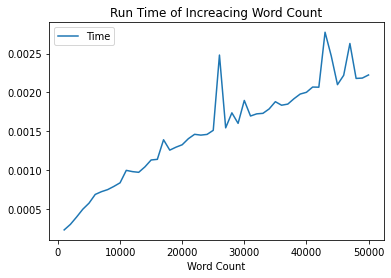

In [ ]:
# Using pandas to plot from data frame
title_ = "Run Time of Increacing Word Count"
df_increacing.plot(x="Word Count", y="Time", title=title_)

***Figure 3.3:***  Scatter plot illustrates the worst case run time of cosine similarity (in sparse representation) with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs)

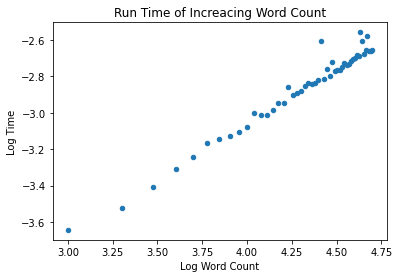

In [ ]:
# Using pandas to scatter plot from data frame
title_ = "Run Time of Increacing Word Count"
df_increacing.plot.scatter(x="Log Word Count", y="Log Time", title=title_)


In [ ]:
CosSparse.slope_df(df_increacing)

,Metric,Actual Data,Log Data
0,Slope,4.112741e-08,0.620986
1,Intercept,4.529338e-04,-5.540516
2,STD Error,2.021150e-09,0.014797


# **Figures: 3.4 - 3.7:** Comparison of Jaccard and Cosine Algorithms

**Pandas Dataframe**

In [ ]:
# Setup 
df_ = CosSparse.compare_algorithms(max_words, plot_length, epochs, "Time")
df_log = CosSparse.compare_algorithms(max_words, plot_length, epochs, "Log Time")
df_sim = CosSparse.compare_algorithms(max_words, plot_length, epochs, "similarity")

***Figure 3.4:*** In this table the run times of jaccards and cosine similarity algorithms are calculated with increacing word counts ranging from 1,000 words to 50,000 words.

In [ ]:
# Display dataframe
df_
#df_log
#df_sim

,Word Count,Log Word Count,Jaccard Time,Cosine Time,Cosine Numpy Time,Cosine Sparse
0,1000,3.000000,0.000182,0.000971,0.000670,0.000191
1,2000,3.301030,0.000186,0.001525,0.000977,0.000299
2,3000,3.477121,0.000244,0.001865,0.001219,0.000389
3,4000,3.602060,0.000288,0.002323,0.001535,0.000484
4,5000,3.698970,0.000338,0.002629,0.001757,0.000565
5,6000,3.778151,0.000390,0.003210,0.002451,0.000629
6,7000,3.845098,0.000424,0.003197,0.002152,0.001250
7,8000,3.903090,0.000507,0.003388,0.002249,0.000744
8,9000,3.954243,0.000560,0.003669,0.002448,0.000833
9,10000,4.000000,0.000632,0.004178,0.002965,0.000844


**Analysis of algorithms in response to increacing size of words**


***Figure 3.5:*** Plot illustrates the worst case runstime of jaccard and cosine similarity algorithms with the size of words increacing from 1000 - 50,000.

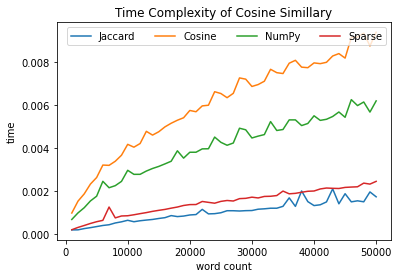

In [ ]:
# Plotting with matplotlib 
plt.plot(df_["Word Count"], df_["Jaccard Time"])
plt.plot(df_["Word Count"], df_["Cosine Time"])
plt.plot(df_["Word Count"], df_["Cosine Numpy Time"])
plt.plot(df_["Word Count"], df_["Cosine Sparse"])
label = ["Jaccard", "Cosine", "NumPy", "Sparse"]
plt.legend(label, loc = 0, ncol = 4)
plt.ylabel("time")
plt.xlabel("word count")
plt.title("Time Complexity of Cosine Simillary")
plt.show()

***Figure 3.6:*** Scatter plot illustrates the worst case run time of jaccard and cosine similarity algorithms with the size of words increacing from 1000 - 50,000 (run time and size of words are represented in logs).

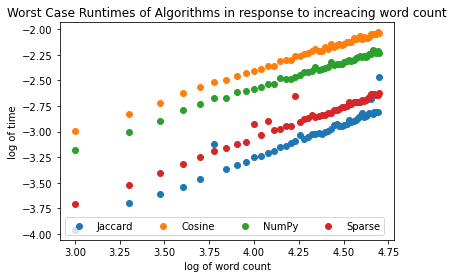

In [ ]:
# Scatter plot with matplotlib
plt.scatter(df_log["Log Word Count"], df_log["Jaccard Time"])
plt.scatter(df_log["Log Word Count"], df_log["Cosine Time"])
plt.scatter(df_log["Log Word Count"], df_log["Cosine Numpy Time"])
plt.scatter(df_log["Log Word Count"], df_log["Cosine Sparse"])
label = ["Jaccard", "Cosine", "NumPy", "Sparse"]
plt.legend(label, loc = 0, ncol = 4)
plt.ylabel("log of time")
plt.xlabel("log of word count")
plt.title("Worst Case Runtimes of Algorithms in response to increacing word count")
plt.show()

***Figure 3.7:*** Metrics for jaccard and cosine algorithms 

In [ ]:
# Display pandas dataframe with metrics 
CosSparse.compare_slopes(df_log, list(df_log["Log Word Count"]))

,label,Jaccard,Cosine,Cosine Numpy,Cosine Sparse
0,Slope,0.674525,0.554367,0.548048,0.616286
1,Intercept,-5.943655,-4.630205,-4.784038,-5.520453
2,STD Error,0.024365,0.005711,0.006577,0.017560


# **==== QUESTION 3 (REPORT) ====**

**Implementation and Analysis Cosine (Sparse Representation)**
 
In contrast to question 2 (dense vector representation), the cosine similarity will be computed using sparse representation directly from key/value pairs (dictionary).
 
Results collected  in figure 3.1 (data frame) suggest that average runtime increases with word count. Respectively, average runtime appears to grow steadily (against word count) despite irregularities seen with the few peaks [figure 3.2] which is also consistent with outliers exhibited in the scatter graph [figure 3.3]. 
 
**Estimation of Constants**

If **$y=ax^{b}$**, then **$log(y) = log(x)b+log(a)$** where **$b$** is the slope and **$a$** is the intercept.  Respectively, the slope is 0.62 and  intercept is -5.54 (**$\approx 6$**) [figure 3.3] meaning that **$y\approx x^{0.62}*10^{-6}$**. This can be verified as $50000^{0.62}*10^{-5.54}=0.0024\approx0.0022$ (result from figure 3.1). Therefore, the worst case runtime can be denoted as **$O(n^{0.62})$**.
 
**Comparing All Algorithms**
 
Although all algorithms appear to follow an uptrend, runtimes of algorithms using dictionaries (sparse) are not only more similar to one another but also produce significantly lower runtimes [figures 3.5-3.6]. However, vectorised cosine algorithms see greater variation with the numpy implementation achieving more efficient runtimes as size of document increases. Considering vectorised cosine algorithms require computation of all frequencies (applying default values where irrelevant), greater sizes of vectorised word counts are employed. Accordingly, when the cosine algorithm uses a dictionary, it employs smaller word counts and directly computes frequencies reducing runtimes. On the other hand, Jaccard’s algorithm focuses on length of the words to find intersections and union (without iteration) which explains why it has the lowest runtime of all algorithms [figures 3.5-3.6]. Nevertheless, all algorithms are dependent on the length of word count and different implementations may lead to different results.


In [ ]:
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results 
a = -5.54# Intercept 
b = 0.62# Slope
x = 50000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

0.002362443347323858

# **==========================**

# **Question 4 Class**

In [ ]:
class AllPair:
  def __init__(self, sphase):
    self.sphase = sphase # Cosine Sparse
    self.jaccard = self.sphase.jaccard # Jaccard class (which is already in the cosine class)
    self.corpus_dict_list = self.get_corp_dict()
    self.word_count = [len(doc.keys()) for doc in self.get_corp_dict()]
    
  # === The method will be used from the jaccards class ===
  # Returns a pandas data frame for displaying slope, intercept and standard deviation error both the actual data and the logs of given data
  # Parameters: Pandas dataframe created using increacing_wordList() (it can be found below) 
  def slope_intercept_std(self, x, y):
    return self.jaccard.slope_intercept_std(x, y)
  
  # Returns a list of dictionaries which represent each doc in the gutenber corpus as bag of words
  def get_corp_dict(self):
    corp_docs = [FreqDist([a for a in gutenberg.words(i)]) for i in gutenberg.fileids()]
    corp_dict = [{word: freq for word, freq in docs.items()} for docs in corp_docs]
    return corp_dict
  
  # Returns a list containing calculations of all pair similarities 
  def all_pair_simmilarity(self):
    jaccard = [[self.jaccard.jaccards(doc_a, doc_b) for doc_b in self.corpus_dict_list] for doc_a in self.corpus_dict_list]
    sparse = [[self.sphase.cosine_sparse_simillarity(doc_a, doc_b) for doc_b in self.corpus_dict_list] for doc_a in self.corpus_dict_list]
    return jaccard, sparse

  # Returns the maximum and minimum similarities as pandas dataframe
  # Parameters: A list of list containung all pair similarity calulation (obtained from all_pair_simmilarity() method)
  def find_min_max(self, my_list):
    remove1 = [[i if i != 1 else min(sim)+0.01 for i in sim] for sim in my_list]
    minimums = [[min(sim)] for sim in remove1]
    maximums = [[max(sim)] for sim in remove1]
    dict_min = {f"Doc {i+1}": val for i, val in enumerate(minimums)}
    dict_max = {f"Doc {i+1}": val for i, val in enumerate(maximums)}
    return pd.DataFrame(data=dict_min), pd.DataFrame(data=dict_max)
  
  # Returns runtimes of jaccards and cosine (sparse) all pair similarities as list of list
  # Parameters: Epochs (epochs) is number of iterations that will be used to find the avergage runtime
  def all_pair_average_runtime(self, epochs):
      # Empty list to gather our results
      jaccard_run_times = []
      sparse_run_times = []

      for docA in self.corpus_dict_list:
        # Empty list for run times each row 
        jaccard_row = []
        sparse_row = []
        for docB in self.corpus_dict_list:
          # Empty list to hold runtime for total epochs 
          jac_rt = []
          sparse_rt = []
          for i in range(epochs):
            # Computing runtimes (jaccard)
            start = time.time()
            self.jaccard.jaccards(docA,docB)
            run_time = time.time() - start
            jac_rt.append(run_time)
            # Computing runtimes (cosine)
            start = time.time()
            self.sphase.cosine_sparse_simillarity(docA,docB)
            run_time = time.time() - start
            sparse_rt.append(run_time)

            if i == epochs-1:
              # Adding average run times of total epoch to list for row
              average_runtime = np.mean(jac_rt)
              jaccard_row.append(average_runtime)

              average_runtime = np.mean(sparse_rt)
              sparse_row.append(average_runtime)
              if len(jaccard_row) == 18:
                # Adding each row to list containing all rows 
                jaccard_run_times.append(jaccard_row)
                sparse_run_times.append(sparse_row)
      # Returning run times for both algorithms as list of list
      return jaccard_run_times, sparse_run_times
  
  # Create dataframe from list of lists
  def create_dataframe(self, data):
    return pd.DataFrame(data={label: data[idx] for idx, label in enumerate([f"Doc {i}" for i in range(1,19)])})

  # Returns the increacing run times of 314 pairs calculated in one list (summing data for 314 iteration to show growth)
  # Paramters: Dataframe with all calulations of all pair runtimes 
  def increacing_byPair(self, df):
    labels = [f"Doc {i}" for i in range(1,19)] # labels in the dataframe
    total = 0 # total time initialized as 0 
    times = [] # Empty list to add increacing time 
    for label in labels:
        for time in list(df[label]):
            total += time
            times.append(total)
    # Returning the logs of data ready for plotting 
    return [np.log10(i) for i in times], [np.log10(i) for i in range(1, 325)]

  def increacing_byEpochJaccard(self):
    # empty list containing our runtimes 
    jac_rt = []
    doc_len = []
    for i in range(1,19):
      # Adjusting size of document where all pair similarities are to be computed 
      doc = self.corpus_dict_list[0:i]
      doc_len.append(i) # Adding length of document to list above
      # initlaizing run time 
      start = time.time()
      # Computing all pair similarities for the size of the doc
      for docA in doc:
        for docB in doc:
          self.jaccard.jaccards(docA,docB)
      # Adding total run time to list above
      run_time = time.time() - start
      jac_rt.append(run_time)
    # Returning logs of results ready for plotting
    return [np.log10(i) for i in jac_rt], [np.log10(i) for i in doc_len]

  def increacing_byEpochCosine(self):
    # empty list containing our runtimes 
    cos_rt = []
    doc_len = []
    for i in range(1,19):
      # Adjusting size of document where all pair similarities are to be computed 
      doc = self.corpus_dict_list[0:i]
      doc_len.append(i) # Adding length of document to list above
      start = time.time()
      # Computing all pair similarities for the size of the doc
      for docA in doc:
        for docB in doc:
          self.sphase.cosine_sparse_simillarity(docA,docB)
      # Adding total run time to list above
      run_time = time.time() - start
      cos_rt.append(run_time)
    # Returning logs of results ready for plotting
    return [np.log10(i) for i in cos_rt], [np.log10(i) for i in doc_len]

# Initializing AlL Pair Class
allPair = AllPair(CosSparse)

# **Figures 4.1 - 4.2:** All Pairs Similiarities

In [ ]:
# Setup
jaccard_sim, sparse_sim = allPair.all_pair_simmilarity()
jaccardMin, jaccardMax = allPair.find_min_max(jaccard_sim)
sparseMin, sparseMax = allPair.find_min_max(sparse_sim)

**Jaccard's all pairs smillilarities**

***Figure 4.1:*** Pandas dataframe with calculations of all pair similarities for all 18 documents in the gutenberg corpus. In the cells below the dataframe are the calculations of maximum and minmium similarity.

In [ ]:
# Display pandas dataframe 
jaccardSim = allPair.create_dataframe(jaccard_sim)
jaccardSim

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,1.000000,0.448781,0.612739,0.132149,0.033271,0.224412,0.077240,0.138325,0.358864,0.327983,0.274260,0.567748,0.426545,0.272937,0.085779,0.121755,0.075753,0.339667
1,0.448781,1.000000,0.575345,0.075149,0.059940,0.378212,0.144949,0.241201,0.473848,0.476826,0.434224,0.384099,0.293718,0.344698,0.151266,0.203255,0.133652,0.314007
2,0.612739,0.575345,1.000000,0.104026,0.043826,0.288768,0.103429,0.181051,0.431214,0.405691,0.349551,0.498328,0.380135,0.321828,0.111554,0.157323,0.099492,0.340455
3,0.132149,0.075149,0.104026,1.000000,0.007082,0.045311,0.014494,0.026807,0.071899,0.063861,0.052062,0.149652,0.174641,0.074757,0.018680,0.026813,0.016302,0.111036
4,0.033271,0.059940,0.043826,0.007082,1.000000,0.112994,0.201222,0.148079,0.066814,0.072348,0.086540,0.032446,0.028379,0.072194,0.178496,0.137164,0.197764,0.046304
5,0.224412,0.378212,0.288768,0.045311,0.112994,1.000000,0.260695,0.389353,0.415572,0.449393,0.498325,0.224760,0.182745,0.302651,0.240566,0.300423,0.213036,0.241884
6,0.077240,0.144949,0.103429,0.014494,0.201222,0.260695,1.000000,0.336380,0.155718,0.174879,0.207725,0.075673,0.061529,0.128989,0.264102,0.234801,0.266598,0.087925
7,0.138325,0.241201,0.181051,0.026807,0.148079,0.389353,0.336380,1.000000,0.256900,0.289133,0.324263,0.138855,0.110451,0.202463,0.279357,0.310967,0.271798,0.157159
8,0.358864,0.473848,0.431214,0.071899,0.066814,0.415572,0.155718,0.256900,1.000000,0.631629,0.574501,0.351035,0.305765,0.335785,0.160220,0.216761,0.142933,0.333194
9,0.327983,0.476826,0.405691,0.063861,0.072348,0.449393,0.174879,0.289133,0.631629,1.000000,0.600124,0.321925,0.276860,0.322573,0.173541,0.234884,0.155685,0.306358


Minimum Similarity for each document

In [ ]:
# Display pandas dataframe 
jaccardMin

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.033271,0.05994,0.043826,0.007082,0.007082,0.045311,0.014494,0.026807,0.066814,0.063861,0.052062,0.032446,0.028379,0.072194,0.01868,0.026813,0.016302,0.046304


Maximum Similarity for each document

In [ ]:
# Display pandas dataframe 
jaccardMax

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.612739,0.575345,0.612739,0.174641,0.201222,0.498325,0.33638,0.389353,0.631629,0.631629,0.600124,0.567748,0.477185,0.348065,0.520428,0.473649,0.520428,0.396534


Maximum and minimum results

In [ ]:
# Finding min and max from pandas dataframe
print(f"Minimum Similarity: {jaccardMin.min(axis=1)}")
print(f"Maximum Similarity: {jaccardMax.max(axis=1)}")

Minimum Similarity: 0    0.007082
dtype: float64
Maximum Similarity: 0    0.631629
dtype: float64


**Cosine (sphase) all pairs smillilarities**

***Figure 4.2:*** Pandas dataframe with calculations of all pair similarities for all 18 documents in the gutenberg corpus. In the cells below the dataframe are the calculations of maximum and minimum similarity.

In [ ]:
# Display pandas dataframe 
sparseSim = allPair.create_dataframe(sparse_sim)
sparseSim

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,1.000000,0.976089,0.981084,0.802430,0.854748,0.913085,0.860146,0.825656,0.914602,0.909199,0.910384,0.961473,0.909514,0.828398,0.859999,0.878289,0.847174,0.825771
1,0.976089,1.000000,0.985069,0.841390,0.883591,0.929556,0.850909,0.836517,0.915253,0.916269,0.909120,0.961670,0.940954,0.879619,0.849402,0.867845,0.842191,0.872930
2,0.981084,0.985069,1.000000,0.818372,0.874555,0.916376,0.841596,0.835783,0.906181,0.904605,0.900936,0.965454,0.924587,0.864311,0.853981,0.872123,0.843780,0.860564
3,0.802430,0.841390,0.818372,1.000000,0.872227,0.867195,0.749395,0.757874,0.850383,0.848108,0.835778,0.826238,0.885142,0.821027,0.808868,0.814520,0.808239,0.843401
4,0.854748,0.883591,0.874555,0.872227,1.000000,0.894530,0.764287,0.819127,0.849989,0.858091,0.853851,0.906870,0.927609,0.919761,0.890933,0.898225,0.894530,0.935862
5,0.913085,0.929556,0.916376,0.867195,0.894530,1.000000,0.893747,0.858827,0.958111,0.963416,0.956480,0.950426,0.951665,0.824393,0.814326,0.839911,0.817095,0.865979
6,0.860146,0.850909,0.841596,0.749395,0.764287,0.893747,1.000000,0.816836,0.893828,0.898563,0.895730,0.877410,0.845174,0.687152,0.772723,0.804635,0.789598,0.717416
7,0.825656,0.836517,0.835783,0.757874,0.819127,0.858827,0.816836,1.000000,0.827657,0.850491,0.824439,0.875676,0.858089,0.745962,0.774000,0.811872,0.813699,0.814404
8,0.914602,0.915253,0.906181,0.850383,0.849989,0.958111,0.893828,0.827657,1.000000,0.987626,0.989541,0.932280,0.938408,0.758495,0.800916,0.833683,0.802943,0.811808
9,0.909199,0.916269,0.904605,0.848108,0.858091,0.963416,0.898563,0.850491,0.987626,1.000000,0.985950,0.934158,0.948072,0.763496,0.788726,0.824808,0.795787,0.821645


Minimum Similarity for each document

In [ ]:
# Display pandas dataframe 
sparseMin


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.80243,0.836517,0.818372,0.749395,0.764287,0.814326,0.687152,0.745962,0.758495,0.763496,0.757471,0.826238,0.845174,0.687152,0.772723,0.804635,0.789598,0.717416


Maximum Similarity for each document

In [ ]:
# Display pandas dataframe 
df=sparseMax.sort_values(by=0, ascending=False, axis=1) 
df

,Doc 9,Doc 11,Doc 10,Doc 3,Doc 2,Doc 1,Doc 16,Doc 17,Doc 15,Doc 12,Doc 6,Doc 13,Doc 5,Doc 18,Doc 14,Doc 7,Doc 4,Doc 8
0,0.989541,0.989541,0.987626,0.985069,0.985069,0.981084,0.978513,0.978513,0.974957,0.965454,0.963416,0.951665,0.935862,0.935862,0.932585,0.898563,0.885142,0.875676


Maximum and minimum similarity results for all pairs 

In [ ]:
# Finding min and max from pandas dataframe
print(f"Minimum Similarity: {sparseMin.min(axis=1)}")
print(f"Maximum Similarity: {sparseMax.max(axis=1)}")

Minimum Similarity: 0    0.687152
dtype: float64
Maximum Similarity: 0    0.989541
dtype: float64


# **Figures 4.3 - 4.4:** Average Runtime of All Pairs Similiarities**

In [ ]:
epochs = 10
jaccard_runtime, sparse_runtime = allPair.all_pair_average_runtime(epochs)

**Jaccard's all pairs average runtimes**

***Figure 4.3:*** Pandas dataframe with calculations of all pair runtimes for all 18 documents in the gutenberg corpus. In the cells below the dataframe are the calculations of maximum and minimum similarity.

In [ ]:
# Display pandas dataframe 
jaccardRuntime = allPair.create_dataframe(jaccard_runtime)
jaccardRuntime

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.004943,0.003254,0.012314,0.006646,0.000878,0.001902,0.000930,0.001527,0.004346,0.003779,0.003151,0.005807,0.008599,0.004492,0.001354,0.001837,0.001477,0.006406
1,0.004127,0.003691,0.007975,0.006209,0.000702,0.001713,0.000792,0.001375,0.004094,0.003470,0.002632,0.004791,0.007987,0.004811,0.001105,0.001544,0.001179,0.006030
2,0.004374,0.003598,0.009745,0.006828,0.000745,0.002259,0.000838,0.001658,0.003993,0.003272,0.003306,0.004944,0.008537,0.004412,0.001401,0.001719,0.001272,0.006158
3,0.004583,0.003585,0.011966,0.009315,0.001503,0.002629,0.001186,0.001843,0.005134,0.004680,0.004501,0.005755,0.010637,0.005858,0.001787,0.002397,0.001892,0.007824
4,0.001930,0.001457,0.007826,0.004427,0.000825,0.001101,0.000486,0.000778,0.002473,0.002012,0.001664,0.002610,0.006206,0.002757,0.000821,0.001197,0.000899,0.004630
5,0.002437,0.001893,0.005952,0.005764,0.000699,0.002015,0.000753,0.001156,0.003101,0.003197,0.002370,0.004255,0.007395,0.003533,0.001000,0.001494,0.001099,0.005688
6,0.001779,0.001788,0.006025,0.004654,0.000463,0.001095,0.000897,0.000825,0.002000,0.001889,0.001643,0.003220,0.006351,0.002792,0.000783,0.001111,0.000875,0.004810
7,0.002029,0.001742,0.009426,0.005417,0.000575,0.001352,0.000653,0.001346,0.002447,0.002093,0.002059,0.003475,0.007005,0.002679,0.000880,0.001288,0.000954,0.005053
8,0.003568,0.002917,0.007078,0.006714,0.000862,0.001987,0.001022,0.001498,0.004755,0.004015,0.004049,0.004785,0.009902,0.004868,0.001265,0.001961,0.001356,0.006929
9,0.003831,0.003117,0.010225,0.006641,0.000850,0.002327,0.000973,0.001497,0.004947,0.004394,0.003476,0.005210,0.009619,0.004631,0.001219,0.001816,0.001322,0.006811


In [ ]:
jaccardMin, jaccardMax = allPair.find_min_max(jaccard_runtime)

Minimum runtime for each document

In [ ]:
# Display pandas dataframe 
jaccardMin

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.001779,0.001457,0.001693,0.004427,0.000463,0.001095,0.000486,0.000778,0.002,0.001889,0.001643,0.002517,0.006206,0.002679,0.000783,0.001111,0.000875,0.00463


Maximum runtime for each document

In [ ]:
# Display pandas dataframe 
jaccardMax

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.005611,0.012334,0.012314,0.009315,0.001503,0.00321,0.001656,0.002191,0.006507,0.006178,0.005124,0.007123,0.01323,0.007099,0.002163,0.003173,0.002577,0.009705


Maximum and minimum runtime results for all pairs

In [ ]:
# Finding min and max from pandas dataframe
print(f"Minimum Runtime: {jaccardMin.min(axis=1)}")
print(f"Maximum Runtime: {jaccardMax.max(axis=1)}")

Minimum Runtime: 0    0.000463
dtype: float64
Maximum Runtime: 0    0.01323
dtype: float64


**Cosine all pairs average runtimes**

***Figure 4.4:*** Pandas dataframe with calculations of all pair runtimes for all 18 documents in the gutenberg corpus. In the cells below the dataframe are the calculations of maximum and minimum similarity.

In [ ]:
# Display pandas dataframe 
sparseRuntime = allPair.create_dataframe(sparse_runtime)
sparseRuntime


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.004845,0.005010,0.005920,0.010406,0.002495,0.004200,0.002520,0.003199,0.006085,0.006584,0.005351,0.007972,0.011699,0.008362,0.003688,0.004782,0.003988,0.010009
1,0.005200,0.003554,0.005561,0.009334,0.001825,0.003294,0.002035,0.002383,0.005084,0.005152,0.004453,0.005859,0.010515,0.007508,0.003060,0.003914,0.003096,0.008729
2,0.006964,0.005127,0.003919,0.009735,0.002140,0.003656,0.002249,0.003377,0.005665,0.005468,0.005214,0.007161,0.010633,0.008417,0.003469,0.004407,0.003540,0.009922
3,0.011121,0.008506,0.009921,0.014887,0.005165,0.006762,0.005409,0.005918,0.010664,0.009478,0.008110,0.010638,0.017839,0.013615,0.006713,0.007922,0.006847,0.016016
4,0.002400,0.001837,0.002382,0.006131,0.000850,0.001490,0.000888,0.001288,0.002527,0.002509,0.001979,0.002718,0.007721,0.003651,0.001293,0.001779,0.001430,0.005842
5,0.004314,0.003676,0.003853,0.007657,0.001581,0.002276,0.001553,0.002239,0.003735,0.004084,0.003546,0.005004,0.009332,0.005949,0.002412,0.002954,0.002636,0.008401
6,0.002308,0.001955,0.002103,0.005988,0.000902,0.001574,0.000872,0.001266,0.002391,0.002363,0.002762,0.003359,0.007456,0.003173,0.001310,0.001798,0.001412,0.005834
7,0.003387,0.002497,0.002812,0.006619,0.001218,0.002050,0.001200,0.001443,0.002994,0.003612,0.002586,0.003439,0.008567,0.004514,0.001861,0.002404,0.001954,0.006981
8,0.008016,0.006261,0.006143,0.011473,0.002842,0.004211,0.003093,0.003424,0.005029,0.006819,0.005407,0.008053,0.013105,0.009267,0.003815,0.006059,0.004246,0.010957
9,0.007390,0.005291,0.006375,0.010343,0.002882,0.004090,0.003037,0.003459,0.007305,0.004880,0.005213,0.007730,0.013777,0.009337,0.003687,0.004618,0.004010,0.010823


In [ ]:
sparseMin, sparseMax = allPair.find_min_max(sparse_runtime)

Minimum runtime for each document

In [ ]:
# Display pandas dataframe 
sparseMin

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.002308,0.001837,0.002103,0.005512,0.00085,0.00149,0.000872,0.001266,0.002391,0.002363,0.001979,0.002718,0.007456,0.003173,0.001293,0.001779,0.001412,0.005834


Maximum runtime for each document

In [ ]:
# Display pandas dataframe 
sparseMax

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18
0,0.012063,0.009921,0.011813,0.01716,0.007609,0.008262,0.006926,0.008054,0.012375,0.012323,0.010623,0.012874,0.01882,0.014772,0.008082,0.009411,0.008142,0.017432


Maximum and minimum runtime results for all pairs

In [ ]:
# Finding min and max from pandas dataframe
print(f"Minimum Runtime: {sparseMin.min(axis=1)}")
print(f"Maximum Runtime: {sparseMax.max(axis=1)}")

Minimum Runtime: 0    0.00085
dtype: float64
Maximum Runtime: 0    0.01882
dtype: float64


# **Figures 4.5 - 4.7:** Analysis of avergage run time and similarity against ascending multiple of word count

In [ ]:
labels = [f"Doc {i}" for i in range(1,19)]
sum_of_wordcount = [[a*i for a in allPair.word_count] for i in allPair.word_count]

# A list containing the sum of the of each document being compared 
sum_of_wordcount_joined = [np.log10(item) for sublist in sum_of_wordcount for item in sublist]

# Joining all run times and similarities from data frame into one list 
# Jaccard
Jaccard_RT_ = [[i for i in jaccardRuntime[label]] for label in labels]
Jaccard_RT_joined = [np.log10(item) for sublist in Jaccard_RT_ for item in sublist]

Jaccard_SIM_ = [[i for i in jaccardSim[label]] for label in labels]
Jaccard_SIM_joined = [np.log10(item) for sublist in Jaccard_SIM_ for item in sublist]
# Cosine(sparse)
Cosine_RT_ = [[i for i in sparseRuntime[label]] for label in labels]
Cosine_RT_joined = [np.log10(item) for sublist in Cosine_RT_ for item in sublist]

Cosine_SIM_ = [[i for i in sparseSim[label]] for label in labels]
Cosine_SIM_joined = [np.log10(item) for sublist in Cosine_SIM_ for item in sublist]



***Figure 4.5:*** Scatter plot of all pair run time (in log) against multiplied word count of documents (in log)

Text(0.5, 1.0, 'All pair runtimes (in log) against multiplied word count of documents (in log)')

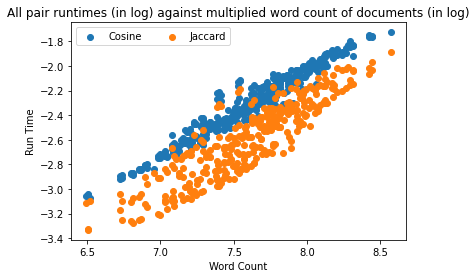

In [ ]:
# Plotting with matplotlib
plt.scatter(sum_of_wordcount_joined, Cosine_RT_joined)
plt.scatter(sum_of_wordcount_joined, Jaccard_RT_joined)
label = ["Cosine", "Jaccard"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Run Time")
plt.xlabel("Word Count")
plt.title("All pair runtimes (in log) against multiplied word count of documents (in log)")

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Cosine All Pair Runtimes")
allPair.slope_intercept_std(sum_of_wordcount_joined, Cosine_RT_joined)

Metrics for Cosine All Pair Runtimes


(0.6817843040111049, -7.492703009317984, 0.0090380817399754)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Jaccard All Pair Runtimes")
allPair.slope_intercept_std(sum_of_wordcount_joined, Jaccard_RT_joined)

Metrics for Jaccard All Pair Runtimes


(0.7037353122005422, -7.939094327020101, 0.019613062269244447)

***Figure 4.6:*** Scatter plot of run time all pair (in log) against all pair smilarity (in log) (in log)

Text(0.5, 1.0, 'All pair similarities (in log) against multiplied word count of documents (in log)')

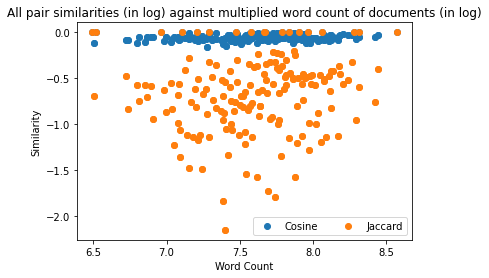

In [ ]:
# Plotting with matplotlib
plt.scatter(sum_of_wordcount_joined, Cosine_SIM_joined)
plt.scatter(sum_of_wordcount_joined, Jaccard_SIM_joined)
label = ["Cosine", "Jaccard"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Similarity")
plt.xlabel("Word Count")
plt.title("All pair similarities (in log) against multiplied word count of documents (in log)")

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Cosine All Pair Runtimes")
allPair.slope_intercept_std(sum_of_wordcount_joined, Cosine_SIM_joined)

Metrics for Cosine All Pair Runtimes


(0.014968718538722139, -0.1726962994551091, 0.0044892305246106295)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Jaccard All Pair Runtimes")
allPair.slope_intercept_std(sum_of_wordcount_joined, Jaccard_SIM_joined)

Metrics for Jaccard All Pair Runtimes


(0.13656279429284618, -1.747511721074422, 0.054299259130465044)

***Figure 4.7:*** Scatter plot of all pair similarities (in log) against all pair run time (in log)


Text(0.5, 1.0, 'All pair similarities (in log) against all pair run time (in log)')

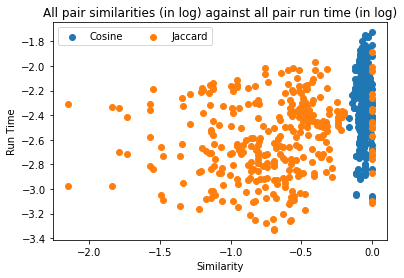

In [ ]:
# Plotting with matplotlib
plt.scatter(Cosine_SIM_joined, Cosine_RT_joined)
plt.scatter(Jaccard_SIM_joined, Jaccard_RT_joined)
label = ["Cosine", "Jaccard"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Run Time")
plt.xlabel("Similarity")
plt.title("All pair similarities (in log) against all pair run time (in log)")

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Cosine All Pair Runtimes")
allPair.slope_intercept_std(Cosine_SIM_joined, Cosine_RT_joined)

Metrics for Cosine All Pair Runtimes


(1.0047654359604912, -2.2566706913011987, 0.4733509409888082)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Jaccard All Pair Runtimes")
allPair.slope_intercept_std(Jaccard_SIM_joined, Jaccard_RT_joined)

Metrics for Jaccard All Pair Runtimes


(0.1346521628694235, -2.5000277539534252, 0.043930294453405794)

# **Figures 4.8 - 4.9:** Analysis of avergage run time and againstincreacing size of documents

***Figure 4.8:*** Scatter plot of runtimes against increacing the 324 of paires computed in the gutenberg corpus from NLTK

Text(0.5, 1.0, 'Run time against increaced number of pairs computed')

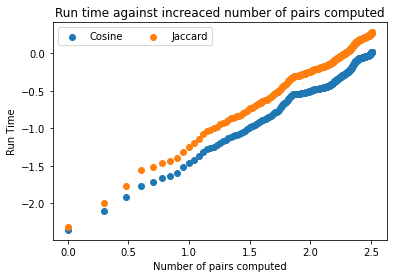

In [ ]:
# Plotting with matplotlib
y, x = allPair.increacing_byPair(jaccardRuntime) 
plt.scatter(x, y)
y_, x_ = allPair.increacing_byPair(sparseRuntime)
plt.scatter(x_, y_)
label = ["Cosine", "Jaccard"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Run Time")
plt.xlabel("Number of pairs computed")
plt.title("Run time against increaced number of pairs computed")



In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Cosine Runtimes")
allPair.slope_intercept_std(x, y)


Metrics for Cosine Runtimes


(0.9482307618755915, -2.402208327861263, 0.0055394418501847195)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Jaccard's Runtimes")
allPair.slope_intercept_std(x_, y_)

Metrics for Jaccard's Runtimes


(0.9832386177138239, -2.217580569369632, 0.004141930385682739)

***Figure 4.9:*** Scatter plot of runtimes against increacing size of docs (from 1 - 18)

(1.7677761470679971, -2.2450121134155747, 0.054053317875850646)

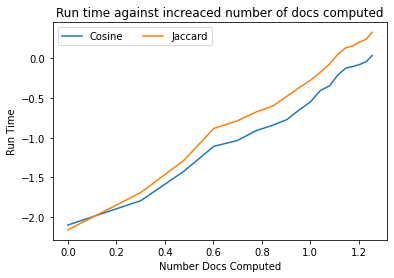

In [ ]:
# Plotting with matplotlib
y, x = allPair.increacing_byEpochJaccard()
plt.plot(x, y)
y_, x_ = allPair.increacing_byEpochCosine()
plt.plot(x_, y_)
label = ["Cosine", "Jaccard"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel("Run Time")
plt.xlabel("Number Docs Computed")
plt.title("Run time against increaced number of docs computed")

allPair.slope_intercept_std(x, y)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Jaccard's Runtimes")
allPair.slope_intercept_std(x, y)

Metrics for Cosine Runtimes


(1.7677761470679971, -2.2450121134155747, 0.054053317875850646)

In [ ]:
# Displaying metrics in pandas using slope_intercept_std() method
print("Metrics for Cosine Runtimes")
allPair.slope_intercept_std(x_, y_)

Metrics for Jaccard's Runtimes


(1.9933356187697817, -2.214722969454929, 0.04023144347276455)

# **==== QUESTION 4 (REPORT) ====**


**Experimentations and Analysis**
 
The largest and smallest of the 18 documents in the gutenberg collection were doc 13 and doc 7 with 19,317 and 1,764 words respectively (check cells below). Jaccard’s similarity measure provided us with coefficients ranging 0.07-0.63 [figure 4.1], while the cosine similarity measure ranged 0.69-0.99 [figure 4.1]. Despite previous finding proportionality between our similarity measures, word count and runtimes (questions 1-2), figures 4.6 & 4.7 neglect any such linkage.
 
However, runtime appears to increase in response to the multiplied word count of each of the 324 pairs plotted for both algorithms [figure 4.5]. Although this implies proportionality between word counts of documents of uneven sizes and runtime, the rate at which the average runtime increases for each of the 324 pairs appears to be steady suggesting that link between uneven word counts are not too significant unless both documents are large. Subsequently, the maximum and minimum runtimes observed in the 324 pairs came from our largest document (doc 13) and smallest documents (doc 5 and 7 with bag of words < 2,000) implying significance of the size of documents being compared [figures 4.3 and 4.4].
 
Following further experimentations, the number of documents increased from 1 to 18 and the plot appears to be less steady for both measures [figure 4.8]. Nevertheless, cosine similarity measures did manage to attain faster runtimes at the start only to be overtaken by jaccards as the number of documents slightly increased [figure 4.9].
 
**Estimations of Constants**
 
If **$y=ax^{b}$**, then **$log(y) = log(x)b+log(a)$** where **$b$** is the slope and **$a$** is the intercept. Accordingly, the slope is 1.76 and the intercept at -2.25 (**$intercept\approx -2$** and **$y\approx x^{1.76}*10^{-2}$**) for the jaccard’s similarity. On the other hand, the slope is 1.99 and the intercept is -2.22 (**$intercept\approx -2$** and **$y\approx x^{1.99}*10^{-2}$**) for cosine similarity. Therefore, the estimated runtimes for 200,000 documents can be denoted as  **$20000^{1.76}*10^{-2.25}\approx12017462$** (jaccard) and **$20000^{1.99}*10^{-2.22}\approx213328898$** (cosine). In this respect, jaccard's measure was almost 18 times faster runtime with **$O(n^{1.76})$** than cosine **$O(n^{1.99})$** when faced with large sample of 200k documents.


In [ ]:
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results 
a = -2.25# Intercept 
b = 1.76# Slope
x = 200000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

12017462.963879632

In [ ]:
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -2.22# Intercept 
b = 1.99# Slope
x = 200000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

213328898.71454725

In [ ]:
213328898/12017462

17.7515766640244

In [ ]:
# Lengths of documents provided as reference 
{f"doc {i+1}": {allPair.word_count[i]} for i in range(18)}

{'doc 1': {7811},
 'doc 10': {8299},
 'doc 11': {6807},
 'doc 12': {9593},
 'doc 13': {19317},
 'doc 14': {10751},
 'doc 15': {3560},
 'doc 16': {5447},
 'doc 17': {4017},
 'doc 18': {14329},
 'doc 2': {6132},
 'doc 3': {6833},
 'doc 4': {13769},
 'doc 5': {1820},
 'doc 6': {4420},
 'doc 7': {1764},
 'doc 8': {3016},
 'doc 9': {8947}}

# **==========================**

# **Question 5 Functions**

In [ ]:
# Returns all combinations of document index in list of list 
# Parameters: Collection of documents
def all_pair(doc):
  return [[[doc_1, doc_2] for doc_2 in range(doc_1+1, len(doc))] for doc_1 in range(len(doc)-1)]

In [ ]:
# Returns combinations of document index in tuples of strings and int
# Parameter: Documents index pairs 
def mapper(doc):
  return [(str(num[0]),num) for num in doc]

In [ ]:
# Reducer function that computes jaccards similarity for single reducing process 
# Mapped index that need to be computed 
def reducer_jac(item):
  word, counts =item
  output=[]
  for i in counts:
    total_intersect = sum({item: min(doc[i[0]][item], doc[i[1]][item]) for item in doc[i[0]].keys() if item in doc[i[1]].keys()}.values())
    union = sum(doc[i[0]].values()) + sum(doc[i[1]].values()) - total_intersect
    jac = total_intersect/union
    output.append(((i[0], i[1]), jac))
  return output

In [ ]:
# Computes dot product of two tokens 
# Parameters: Two tokens in sparse representation
def dot( tok_a, tok_b):
  # Adjusting matrix based on sizer
  if len(tok_a) < len(tok_b):
    A, B = tok_a, tok_b
  else:
    B, A = tok_a, tok_b
  # Returning the dot product of the two
  return sum([freq * B.get(word,0) for word, freq in A.items()])

In [ ]:
# Reducer function that computes cosine similarity for single reducing process 
# Mapped index that need to be computed 
def reducer_cos(item):
  (word,counts)=item
  return [((i[0], i[1]), dot(doc[i[0]], doc[i[1]])/np.sqrt(dot(doc[i[0]], doc[i[0]])*dot(doc[i[1]], doc[i[1]]))) for i in counts]

In [ ]:
# Map reduce algorithm
# Parameter: Collection of duments (doc)
# Parameter: Mapping function
# Parameter: Reducer function (either jaccards or cosine)
# Parameter: Map/Reduce processes as int
def map_reduce_parallel(doc, mapper, reducer, mapprocesses=3,reduceprocesses=2):
  outputs=[]
  collector=defaultdict(list)  
  doc_allpair = all_pair(doc)
  mappool = Pool(processes=mapprocesses)
  #map stage
  mapresults=mappool.map(mapper,doc_allpair)
  mappool.close()
  collector=defaultdict(list)
  for mapresult in mapresults:
    for key, value in mapresult:     #pass each input to the mapper function and receive back each key,value pair yielded
      collector[key].append(value)     #append the value to the list for that key in the intermediate store
  reducepool = Pool(processes=reduceprocesses)
  #reduce stage
  reduceresults=reducepool.map(reducer,collector.items())
  reducepool.close()
  for reduceresult in reduceresults:
    outputs+=reduceresult
  return outputs

In [ ]:
# Computes average runtime using map reduce for number of epochs 
# Check map reduce parameters above 
def average_runtime_mapReduce(doc, mapper, reducer, epoch, map, red):
  times = []
  for i in range(epoch):
    start = time.time()
    ans = map_reduce_parallel(doc, mapper, reducer, map, red)
    runtime = time.time() - start 
    times.append(runtime)
  return np.mean(times)


In [ ]:
# Experiments map/reduces processes between 1-4 and returns all outputs
# Check map reduce parameters above 
def find_optimal_process(doc, mapper, reducer):
  myDict = {}
  for map in range(1, 5):
    for red in range(1, 5):
      start = time.time()
      ans = map_reduce_parallel(doc, mapper, reducer, map, red)
      runtime = time.time() - start
      myDict[f"{map}: {red}"] = runtime
  return pd.DataFrame({"Map: Reduce": list(myDict.keys()), "Runtime": list(myDict.values())})

In [ ]:
# Computes average runtimes for the original implmentations without map reduce over number of epochs 
# Parameter: Collection of documents (doc)
# Parameter: Similarity function (either jaccards or cosine in sparse representation)
def average_runtime_original(doc, function_sim, epoch):
  times = []

  for i in range(epoch):
    start = time.time()
    for tok_a in range(len(doc)):
      for tok_b in range(i+1, len(doc)):
        ans = function_sim(doc[tok_a], doc[tok_b])
        
    runtime = time.time() - start
    times.append(runtime)

    
  print(times)
  return np.mean(times)


In [ ]:
# Setup
doc = allPair.corpus_dict_list
epoch = 10


# **Figure 5.1:** Jaccard's All Pair Similarities - Map Reduce

**Jaccards all pair similarities**

***Figure 5.1:*** Dataframe with jaccards all pari similarities computed using map reduce and then adding original implementations for validation

In [ ]:
# Computing jaccard's all pair smilarities using map reduce 
jac_mapReduceSim = map_reduce_parallel(doc, mapper, reducer_jac)
docs, sim = [x for x, y in jac_mapReduceSim[:10]], [y for x, y in jac_mapReduceSim[:10]]
df = pd.DataFrame(data={"Docs": docs, "Similarity (Map Reduce)": sim})
df 

,Docs,Similarity (Map Reduce)
0,"(0, 1)",0.448781
1,"(0, 2)",0.612739
2,"(0, 3)",0.132149
3,"(0, 4)",0.033271
4,"(0, 5)",0.224412
5,"(0, 6)",0.077240
6,"(0, 7)",0.138325
7,"(0, 8)",0.358864
8,"(0, 9)",0.327983
9,"(0, 10)",0.274260


**Testing jaccards map reduce function for correctness**

In [ ]:
# Adding original resulst
tokens = list(df["Docs"])
sims = [Jac.jaccards(doc[tok_a], doc[tok_b]) for tok_a, tok_b in tokens]
df["similarity (original)"] = sims
df

,Docs,Similarity (Map Reduce),similarity (original)
0,"(0, 1)",0.448781,0.448781
1,"(0, 2)",0.612739,0.612739
2,"(0, 3)",0.132149,0.132149
3,"(0, 4)",0.033271,0.033271
4,"(0, 5)",0.224412,0.224412
5,"(0, 6)",0.077240,0.077240
6,"(0, 7)",0.138325,0.138325
7,"(0, 8)",0.358864,0.358864
8,"(0, 9)",0.327983,0.327983
9,"(0, 10)",0.274260,0.274260


# **Figure 5.2:** Consine All Pair Similarities - Map Reduce

**Cosine all pair similarities** Dataframe with cosine all pair similarities computed using map reduce 

***Figure 5.2:*** Dataframe with cosine all pair similarities computed using map reduce and then adding original implementations for validation

In [ ]:
# Computing jaccard's all pair smilarities using map reduce 
cos_mapReduceSim = map_reduce_parallel(doc, mapper, reducer_cos)
docs, sim = [x for x, y in cos_mapReduceSim[:10]], [y for x, y in cos_mapReduceSim[:10]]
df = pd.DataFrame(data={"Docs": docs, "Similarity (Map Reduce)": sim})
df

,Docs,Similarity (Map Reduce)
0,"(0, 1)",0.976089
1,"(0, 2)",0.981084
2,"(0, 3)",0.802430
3,"(0, 4)",0.854748
4,"(0, 5)",0.913085
5,"(0, 6)",0.860146
6,"(0, 7)",0.825656
7,"(0, 8)",0.914602
8,"(0, 9)",0.909199
9,"(0, 10)",0.910384


**Testing cosine map reduce function for correctness**

In [ ]:
# Adding original resulst
tokens = list(df["Docs"])
sims = [CosSparse.cosine_sparse_simillarity(doc[tok_a], doc[tok_b]) for tok_a, tok_b in tokens]
df["similarity (original)"] = sims
df

,Docs,Similarity (Map Reduce),similarity (original)
0,"(0, 1)",0.976089,0.976089
1,"(0, 2)",0.981084,0.981084
2,"(0, 3)",0.802430,0.802430
3,"(0, 4)",0.854748,0.854748
4,"(0, 5)",0.913085,0.913085
5,"(0, 6)",0.860146,0.860146
6,"(0, 7)",0.825656,0.825656
7,"(0, 8)",0.914602,0.914602
8,"(0, 9)",0.909199,0.909199
9,"(0, 10)",0.910384,0.910384


# **Figures 5.3 - 5.4:** Finding Optimal Runtime Parameters

**Optimal Runtime Parameters For Jaccard Similarity**

***Figure 5.3:*** Optimal parameter for map reduce function (jaccards)

In [ ]:
result_df = find_optimal_process(doc, mapper, reducer_jac)
df_sorted = result_df.sort_values(by="Runtime", ascending=True, axis=0)
df_sorted.head()

,Map: Reduce,Runtime
5,2: 2,0.544425
9,3: 2,0.553069
1,1: 2,0.555311
2,1: 3,0.582034
0,1: 1,0.587228


**Optimal Runtime Parameters For Cosine Similarity**

***Figure 5.4:*** Optimal parameter for map reduce function (cosine)

In [ ]:
result_df = find_optimal_process(doc, mapper, reducer_cos)
df_sorted = result_df.sort_values(by="Runtime", ascending=True, axis=0)
df_sorted.head()

,Map: Reduce,Runtime
1,1: 2,0.756028
9,3: 2,0.772447
2,1: 3,0.775210
13,4: 2,0.778645
5,2: 2,0.783454


# **Figures 5.5 - 5.6:** Comparing Optimal Runtimes of Map Reduce to Result Obtained From Original Function

***Figure 5.5:*** Average run time over 10 epoch using map reduce and original measure for the jaccard and cosine algorithms 

In [ ]:
# Average run times of all pair cosine similarity with and without map reduce
cosine_map_reduce = average_runtime_mapReduce(doc, mapper, reducer_cos, epoch, 1, 2)
cosine_original = average_runtime_original(doc, CosSparse.cosine_sparse_simillarity, epoch)
# Average run times of all pair jaccard's similarity with and without map reduce
jaccard_map_reduce = average_runtime_mapReduce(doc, mapper, reducer_jac, epoch, 2, 2)
jaccard_original = average_runtime_original(doc, Jac.jaccards, epoch)
# Creating pandas dataframe 
labels = ["Cosine Map Reduce", "Cosine Original", "Jaccard Map Reduce", "Jaccard Original"]
data = [cosine_map_reduce, cosine_original, jaccard_map_reduce, jaccard_original]
df = pd.DataFrame({"Runtime Label": labels, "Runtime":data})
df

[1.5121378898620605, 1.4204561710357666, 1.3327605724334717, 1.1703362464904785, 1.1189086437225342, 1.10030198097229, 1.0402491092681885, 1.0106589794158936, 0.9200470447540283, 0.8020610809326172]
[0.8586587905883789, 0.809138298034668, 0.7366511821746826, 0.6669106483459473, 0.6365001201629639, 0.586799144744873, 0.5831060409545898, 0.5295431613922119, 0.4667656421661377, 0.4294121265411377]


,Runtime Label,Runtime
0,Cosine Map Reduce,0.937858
1,Cosine Original,1.142792
2,Jaccard Map Reduce,0.583560
3,Jaccard Original,0.630349


In [ ]:
# Percentage decreace in jaccards runtime 
(1-(0.58/0.63))*100

7.936507936507942

In [ ]:
# Percentage decreace in cosine runtime 
(1-(0.93/1.14))*100

18.421052631578938

***Figure 5.6:*** Bar graph of average runtimes using map reduce and original measures for jaccrd and cosine algorithm 

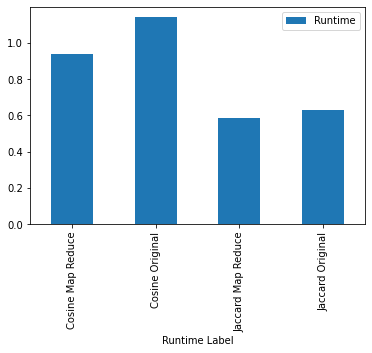

In [ ]:
df.plot.bar(x="Runtime Label", y="Runtime")

# **==== QUESTION 5 (REPORT) ====**

**Implementation**

Map-reduce parallel computing algorithms can be viewed as a reliable and effective procedure to process big data which can reduce runtimes. Consisting of two distinctive tasks map and reduce, the implementation is as follows: 

1. All indexes (0-17) of documents are combined and mapped (based on the number of mapping processes given) by being processed into key/value pairs which can be sorted and shuffled before being fed to the reducer.
2. All map outputs with the same keys are then passed to a single reducer aggregating their values and enabling the computation of their similarity indexes simultaneously based on the number of reduce processes used. 

**Analysis**

Figures 5.1 & 5.2 confirm the algorithms produce correct jaccard and cosine similarity index as computed in question 4. Considering parameters for map and reduce processes can lead to different runtimes, experiments are carried out to find the optimal implementations of the map reduce algorithm. The optimal implementation of map and reduce processes were 2 and 2 for jaccard's similarity and 2 and 1 for cosine similarity respectively [figures 5.3-5.4]. Accordingly, the average runtime (10 epochs) of jaccard's similarity was 0.58 using optimal parameters map reduce parameters compared to 0.63 using the original implementation. Likewise, the average runtime of the cosine similarity was 0.94 using the optimal map reduce parameters compared to 1.14 using the original implementation [figure 5.5]. Overall, map reduce had a greater impact cosine runtime [figure 5.6] decreased by 18% compared to jaccards which decreased by 8%.




# **==========================**

# **==== Conclusion ====**

Experimentations in question 3 suggest that algorithms in sparse representations had the lowest worst case runtimes **$O(n^{0.68})$** (jaccard) and **$O(n^{0.62})$** (cosine) while vectorised algorithms produced **$O(n^{0.55})$** (original cosine and numpy). Although jaccard's mesure performed best, estimates show that the similarity measures with smallest slopes to outperform when the data is large enough (when word count > $10^{13}$) [check cells below]. Although the jaccard's runtime time was superior to cosine when computing all pair similarities, the map reduce function had a greater impact on cosine similarity with a reduction of 18%. Overall, the size of the data proved to be an important factor to consider when implementing the algorithms for the best runtimes. 

In [ ]:
# Jaccards 
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -5.94# Intercept 
b = 0.68# Slope
x = 10000000000000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

794.3282347242819

In [ ]:
# Vectorised Cosine (original)
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -4.63# Intercept 
b = 0.55# Slope
x = 10000000000000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

331.13112148259165

In [ ]:
# Vectorised Cosine (Numpy)
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -4.78# Intercept 
b = 0.55# Slope
x = 10000000000000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

234.4228815319924

In [ ]:
# Sparse Cosine 
# Run code to get the estimated time for 50,000 word count 
# Estimates for the run time can then be compared actual results in figure 1.1
a = -5.52# Intercept 
b = 0.62# Slope
x = 10000000000000# Word Count
y = 10**a * x**b # Y is the estimated runtime 
y

346.73685045253194